In [19]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [20]:
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai_api_key)

# result = llm.invoke("What is the capital of France?")

# print(result.content)

In [21]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )
    
structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output)
print(output.search_query)
print(output.justification)    

search_query='Calcium CT score and its relationship with high cholesterol' justification='This query aims to explore the connection between calcium scores obtained from CT scans and cholesterol levels, which is relevant for understanding cardiovascular health risks.'
Calcium CT score and its relationship with high cholesterol
This query aims to explore the connection between calcium scores obtained from CT scans and cholesterol levels, which is relevant for understanding cardiovascular health risks.


In [22]:
def multiply(a: int, b:int):
    return a * b

def add (a:int, b:int):
    return a + b

llm_with_tools = llm.bind_tools([multiply, add])

response = llm_with_tools.invoke("what is 2 times 117 which then add 3000 ?")
response.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 117},
  'id': 'call_w1O7eJyqSHErOFvCLNZhFrLe',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 3000, 'b': 0},
  'id': 'call_OFq3pIb4WLH3dngFCNYyym4k',
  'type': 'tool_call'}]

In [30]:
from typing_extensions import TypedDict

#Group State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


def generate_joke(state: State):
    """First llm call to generate initial joke"""
    msg = llm.invoke(f"write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second llm call to improve the joke"""
    msg = llm.invoke(f"make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third llm call to finalize the joke"""
    msg = llm.invoke(f"Add a suprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function
def check_puncline(state: State):
    """Gate function to check if joke has a punchline"""
    
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

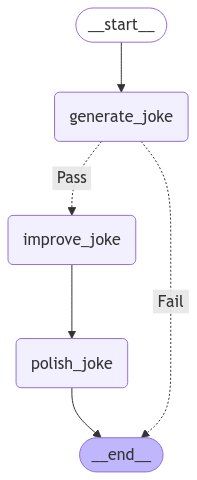

In [31]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# build workflow
workflow = StateGraph(State)

# add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_puncline, {"Pass": "improve_joke", "Fail": END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# compile
chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [32]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why did the cat sit on the computer?

Because it wanted to keep an “eye-con” on the mouse!

--- --- ---

Final joke:
Why did the cat sit on the computer? 

Because it wanted to keep an “eye-con” on the mouse—until it realized the mouse was actually a virtual reality game and it got trapped in the screen chasing digital mice!
